In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-03-01 01:17:40.520411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load your data
df = pd.read_csv('sorted_stock_data_cleaned_nica.csv')  # Replace with your file
print(df.head())


    Open   High    Low  Close  per_change     Qty    EPS         PE
0  678.0  666.0  658.0  660.0         0.0  3547.0  17.94  36.789298
1  660.0  660.0  647.0  651.0         0.0  5758.0  17.94  36.287625
2  651.0  655.0  644.0  646.0         0.0  6085.0  17.94  36.008919
3  646.0  651.0  642.0  648.0         0.0  6977.0  17.94  36.120401
4  648.0  651.0  643.0  648.0         0.0  3303.0  17.94  36.120401


In [3]:
# Ensure all 8 columns are present (adjust if needed)
feature_columns = ['Open', 'High', 'Low', 'Close', 'per_change', 'Qty', 'EPS', 'PE']  # Your 8 features
data = df[feature_columns].values

In [4]:
# Scale all 8 features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Sequence creation function
def create_sequences_multivariate(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])   # n_steps timesteps, each with 8 features
        y.append(data[i+n_steps])      # Predict all 8 features at next step
    return np.array(X), np.array(y)

In [6]:
# Parameters
n_steps = 60  # Past 60 days used for prediction


In [7]:
# Create sequences
X, y = create_sequences_multivariate(scaled_data, n_steps)

In [8]:
# Train-test split
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Define Bidirectional LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, 8)),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(8)
    
])
# model.add(LSTM(128, return_sequences=True), input_shape=(n_steps, 8))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(64, return_sequences=False)))
# model.add(Dropout(0.3))
# model.add(Dense(8))  # Predict all 8 features at once

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]


In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=callbacks)

In [ ]:
model.save('final_model_60.keras')

In [14]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
model = load_model('final_model_60.keras')

In [ ]:

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [16]:
## for the X_train
train_result=model.predict(X_train)
train_result_inverse=scaler.inverse_transform(train_result)
train_result_close=train_result_inverse[:, 3]


53/53 [==============================] - 2s 22ms/step


In [17]:
## for the X_train
test_result=model.predict(X_test)
test_result_inverse=scaler.inverse_transform(test_result)
test_result_close=test_result_inverse[:, 3]


6/6 [==============================] - 0s 22ms/step


In [18]:
# Function to predict future days recursively (all 8 features)
def predict_future_multivariate(model, data, scaler, n_steps, future_days):
    predicted = []
    current_sequence = data[-n_steps:]  # Last window of data

    for _ in range(future_days):
        prediction = model.predict(current_sequence.reshape(1, n_steps, 8), verbose=0)
        predicted.append(prediction[0])

        # Append predicted row to current sequence for next prediction
        current_sequence = np.vstack([current_sequence[1:], prediction])

    # Inverse transform all predicted data (8 features)
    predicted_array = np.array(predicted)
    predicted_prices = scaler.inverse_transform(predicted_array)
    return predicted_prices

In [19]:
# Predict next 30 days
future_days = 500
future_prices = predict_future_multivariate(model, scaled_data, scaler, n_steps, future_days)

In [20]:
# Plot actual vs future Close prices
actual_close_prices = df['Close'].values

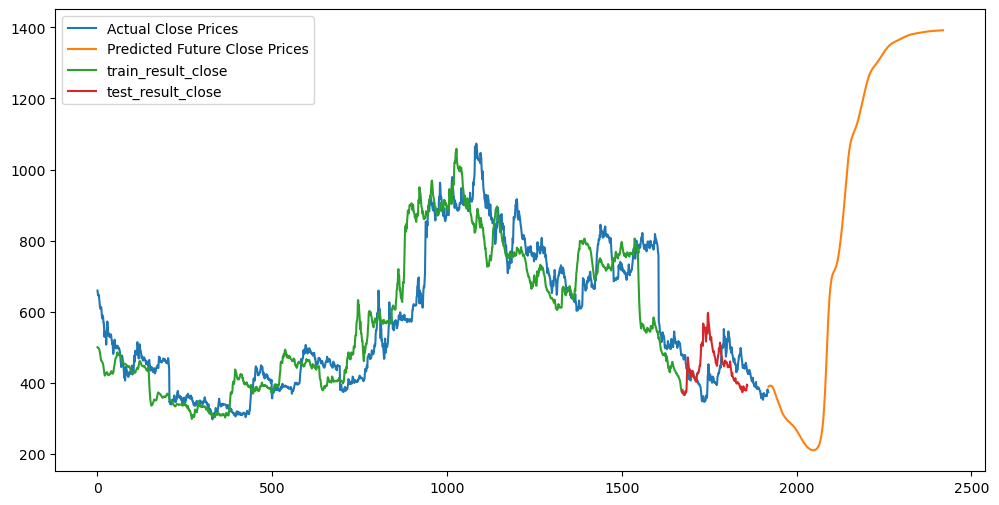

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(actual_close_prices, label='Actual Close Prices')
plt.plot(range(len(actual_close_prices), len(actual_close_prices) + future_days), future_prices[:, 3], label='Predicted Future Close Prices')
plt.plot(train_result_close,label="train_result_close" )
plt.plot(range(len(train_result_close), len(train_result_close)+len(test_result_close)),test_result_close,label="test_result_close" )
plt.legend()
plt.show()

In [22]:
# Print predicted future prices (all features for each day)
future_df = pd.DataFrame(future_prices, columns=feature_columns)
print(future_df)

            Open         High          Low        Close  per_change  \
0     389.237274   396.684143   381.705566   390.180603   -0.050564   
1     390.349792   397.171539   382.428497   390.836945   -0.071728   
2     391.500946   398.003784   383.200806   391.550354   -0.080628   
3     392.432953   398.598999   383.551483   392.151917   -0.109436   
4     393.030457   399.254272   383.728851   392.585144   -0.123472   
..           ...          ...          ...          ...         ...   
495  1341.163574  1323.097900  1404.810303  1391.450317   -0.111580   
496  1341.231079  1323.153687  1404.869629  1391.507080   -0.110903   
497  1341.297729  1323.208740  1404.928345  1391.563354   -0.110228   
498  1341.364136  1323.263428  1404.986694  1391.619141   -0.109561   
499  1341.429443  1323.317505  1405.044434  1391.674194   -0.108897   

              Qty         EPS          PE  
0    41447.039062    1.609789  167.988846  
1    38325.121094    1.809982  164.014526  
2    35863.8437

In [23]:
# Save to CSV if needed
future_df.to_csv('predicted_future_prices.csv', index=False)